# The relationship between airbnb density and crime in neighbourhoods in London

## CASA0013: Foundations of Spatial Data Science

### Student Ids: zczltsu, ucfnhpr, ucbq793, ucfnuoc



## Things to check
- does the datafile have to be included in my github repo?

## Setting up
### Import Packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re
from scipy.stats import zscore

In [2]:
from zipfile import ZipFile
import glob

In [3]:
try:
    import mgwr
except ImportError:
    from pip._internal import main as pip
    pip.main(['install', '--user', 'mgwr'])
    import mgwr

/opt/conda/lib/python3.10/site-packages/spglm/utils.py:367: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if resetlist is not ():


In [4]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap

### Cacheing data file function
The following code creates a function for cacheing datafiles 

In [5]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## Reading in the data
Datasets to be used for this analysis
- Airbnb data from Inside Airbnb
    
- Crime data 
    

In [6]:
# Airbnb data
airbnb_2022_url = 'https://orca.casa.ucl.ac.uk/~jreades/data/2022-09-10-listings.csv.gz'
ddir  = os.path.join('data', 'raw') # destination directory
airbnb = pd.read_csv(cache_data(airbnb_2022_url, ddir), compression='gzip', low_memory=False)
print(f"Data frame is {airbnb.shape[0]:,} x {airbnb.shape[1]}")

Found data/raw/2022-09-10-listings.csv.gz locally!
Data frame is 69,351 x 75


In [7]:
# Crime data
# first read in the zip file
crime_2022_url = "https://github.com/ntsuchiyama/CASA0013_data_policy/raw/main/c0319ac17d3039141b5b9142ab187f40775d9622.zip"
cache_data(crime_2022_url, ddir)

Found data/raw/c0319ac17d3039141b5b9142ab187f40775d9622.zip locally!


'data/raw/c0319ac17d3039141b5b9142ab187f40775d9622.zip'

In [8]:
# read the files contained in the zip file into one dataframe
crime_zip_path = "data/raw/c0319ac17d3039141b5b9142ab187f40775d9622.zip"
crime_org = pd.concat(
    [pd.read_csv(ZipFile(crime_zip_path).open(i)) for i in ZipFile(crime_zip_path).namelist()],
    ignore_index=True)

In [9]:
lsoa_msoa_url = "https://github.com/ntsuchiyama/CASA0013_data_policy/raw/main/2011%20_OA-LSOA-MSOA-LA.csv"
lsoa_msoa_org = pd.read_csv(cache_data(lsoa_msoa_url, ddir))

Found data/raw/2011%20_OA-LSOA-MSOA-LA.csv locally!


In [10]:
msoa_atlas_url = "https://data.london.gov.uk/download/msoa-atlas/20264159-36cb-4aa2-8371-ae884ae83e88/msoa-data.csv"
msoa_atlas_org = pd.read_csv(cache_data(msoa_atlas_url, ddir), encoding = 'unicode_escape')
print(f"Data frame is {msoa_atlas_org.shape[0]:,} x {msoa_atlas_org.shape[1]}")

Found data/raw/msoa-data.csv locally!
Data frame is 984 x 207


In [11]:
msoas_org = gpd.read_file(cache_data('https://github.com/ntsuchiyama/CASA0013_data_policy/raw/main/MSOA_(Dec_2011)_Boundaries_Generalised_Clipped_(BGC)_EW_V3.zip', 
               os.path.join('data','geo')), driver='ESRI Shapefile')
msoas_org.crs

Found data/geo/MSOA_(Dec_2011)_Boundaries_Generalised_Clipped_(BGC)_EW_V3.zip locally!


<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [12]:
msoa_pop_url = "https://github.com/ntsuchiyama/CASA0013_data_policy/raw/main/sape23dt15mid2020msoaquinaryestimatesunformatted.xlsx"
msoa_pop = pd.read_excel(
    cache_data(msoa_pop_url, ddir), 
    "Mid-2020 Persons", # Which sheet is the data in?
    header=[4])    

Found data/raw/sape23dt15mid2020msoaquinaryestimatesunformatted.xlsx locally!


/opt/conda/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


## Data Cleaning 

In [13]:
# check the original data frame
msoas_org

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,geometry
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,7e1c3fbc-cc47-4e16-a505-d89e93921c28,"POLYGON ((532135.138 182198.131, 532158.250 18..."
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,9f32701c-7edc-4f73-b8c2-a1afac813fbb,"POLYGON ((548881.563 190845.265, 548881.125 19..."
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,7687f18e-6c8e-4afb-9c98-a9e633e00dd6,"POLYGON ((549102.438 189324.625, 548954.517 18..."
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,67259638-dce5-461c-82f7-8fbac8335b66,"POLYGON ((551550.056 187364.705, 551478.000 18..."
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,dadad0f1-384f-4686-9535-5026812db2a9,"POLYGON ((549099.634 187656.076, 549161.375 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...
7196,7197,W02000419,Denbighshire 017,Sir Ddinbych 017,302419,380866,-3.466210,53.31571,2.706356e+06,9286.321706,51dedc90-50b7-415b-a3eb-7b676fbaada8,"POLYGON ((302972.663 381406.090, 303008.064 38..."
7197,7198,W02000420,Wrexham 020,Wrecsam 020,336850,353655,-2.944080,53.07638,7.918321e+07,68550.337005,0f10e119-235d-4299-a2f0-11ad45049ca3,"POLYGON ((335857.094 359909.500, 335987.000 35..."
7198,7199,W02000421,Ceredigion 011,Ceredigion 011,271405,266658,-3.886550,52.28298,7.694416e+08,186339.966460,dfae0ae0-ac1c-4983-88e7-7dd9f10c113e,"POLYGON ((281652.906 291392.187, 281772.021 29..."
7199,7200,W02000422,Cardiff 048,Caerdydd 048,319643,174132,-3.158050,51.46043,6.518026e+06,20928.073674,bdf73681-6c88-4e58-81a7-f783e9300a2a,"MULTIPOLYGON (((319194.251 172507.198, 319173...."


We need to remove the areas which do not belong to London - we will use the lsoa and msoa lookup dataframe in London.

In [14]:
# check lsoa and msoa lookup dataframe
lsoa_msoa_org

,OA11CD,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,Inner_Outer
0,E00000001,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
1,E00000003,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
2,E00000005,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
3,E00000007,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
4,E00000010,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,Inner London
...,...,...,...,...,...,...,...,...
25048,E00008185,E01001644,Greenwich 038D,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25049,E00008186,E01001638,Greenwich 038A,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25050,E00008187,E01001638,Greenwich 038A,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25051,E00176525,E01001644,Greenwich 038D,E02006931,Greenwich 038,E09000011,Greenwich,Outer London


In [15]:
# remove column 'OA11CD' as it is not necessary
lsoa_msoa = lsoa_msoa_org.drop('OA11CD', axis=1)
lsoa_msoa

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,Inner_Outer
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
1,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
2,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
3,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
4,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,Inner London
...,...,...,...,...,...,...,...
25048,E01001644,Greenwich 038D,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25049,E01001638,Greenwich 038A,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25050,E01001638,Greenwich 038A,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25051,E01001644,Greenwich 038D,E02006931,Greenwich 038,E09000011,Greenwich,Outer London


In [16]:
lsoa_msoa

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,Inner_Outer
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
1,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
2,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
3,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
4,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,Inner London
...,...,...,...,...,...,...,...
25048,E01001644,Greenwich 038D,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25049,E01001638,Greenwich 038A,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25050,E01001638,Greenwich 038A,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25051,E01001644,Greenwich 038D,E02006931,Greenwich 038,E09000011,Greenwich,Outer London


In [17]:
lsoa_msoa.drop_duplicates(inplace = True)
lsoa_msoa

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,Inner_Outer
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
4,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,Inner London
8,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,Inner London
16,E01032739,City of London 001F,E02000001,City of London 001,E09000001,City of London,Inner London
17,E01032740,City of London 001G,E02000001,City of London 001,E09000001,City of London,Inner London
...,...,...,...,...,...,...,...
25021,E01001638,Greenwich 038A,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25023,E01001641,Greenwich 038B,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25025,E01001642,Greenwich 038C,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25031,E01033746,Greenwich 038E,E02006931,Greenwich 038,E09000011,Greenwich,Outer London


In [18]:
msoa_london = lsoa_msoa.drop(['LSOA11CD', 'LSOA11NM'], axis = 1)
msoa_london

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,Inner_Outer
0,E02000001,City of London 001,E09000001,City of London,Inner London
4,E02000001,City of London 001,E09000001,City of London,Inner London
8,E02000001,City of London 001,E09000001,City of London,Inner London
16,E02000001,City of London 001,E09000001,City of London,Inner London
17,E02000001,City of London 001,E09000001,City of London,Inner London
...,...,...,...,...,...
25021,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25023,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25025,E02006931,Greenwich 038,E09000011,Greenwich,Outer London
25031,E02006931,Greenwich 038,E09000011,Greenwich,Outer London


In [19]:
msoa_london.drop_duplicates(inplace = True)
msoa_london.shape

(983, 5)

In [20]:
# merge the msoas with msoa dataframe for London (originally from lsoa and msoa lookup dataframe)
msoas = msoas_org.merge(msoa_london, on = "MSOA11CD", how = 'inner')
msoas

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,geometry,MSOA11NM_y,LAD11CD,LAD11NM,Inner_Outer
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,7e1c3fbc-cc47-4e16-a505-d89e93921c28,"POLYGON ((532135.138 182198.131, 532158.250 18...",City of London 001,E09000001,City of London,Inner London
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,9f32701c-7edc-4f73-b8c2-a1afac813fbb,"POLYGON ((548881.563 190845.265, 548881.125 19...",Barking and Dagenham 001,E09000002,Barking and Dagenham,Outer London
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,7687f18e-6c8e-4afb-9c98-a9e633e00dd6,"POLYGON ((549102.438 189324.625, 548954.517 18...",Barking and Dagenham 002,E09000002,Barking and Dagenham,Outer London
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,67259638-dce5-461c-82f7-8fbac8335b66,"POLYGON ((551550.056 187364.705, 551478.000 18...",Barking and Dagenham 003,E09000002,Barking and Dagenham,Outer London
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,dadad0f1-384f-4686-9535-5026812db2a9,"POLYGON ((549099.634 187656.076, 549161.375 18...",Barking and Dagenham 004,E09000002,Barking and Dagenham,Outer London
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,6784,E02006927,Greenwich 034,Greenwich 034,540764,175168,0.024735,51.45799,2.526112e+06,8592.913078,a062a326-05de-4ba9-9cab-4ea7f358a859,"POLYGON ((541029.881 176265.023, 541101.997 17...",Greenwich 034,E09000011,Greenwich,Outer London
979,6785,E02006928,Greenwich 035,Greenwich 035,537902,177439,-0.015540,51.47910,5.405753e+05,6849.063388,91390d2d-006c-4e6f-8b6a-3054ec217dec,"MULTIPOLYGON (((537379.750 177482.937, 537369....",Greenwich 035,E09000011,Greenwich,Outer London
980,6786,E02006929,Greenwich 036,Greenwich 036,540018,179089,0.015558,51.49341,2.550052e+06,13109.533457,ecbb9dfd-356d-4e36-9470-6919073c856e,"POLYGON ((540054.362 179353.134, 540220.354 17...",Greenwich 036,E09000011,Greenwich,Outer London
981,6787,E02006930,Greenwich 037,Greenwich 037,540116,178336,0.016670,51.48662,8.679553e+05,7492.395145,e1b550d9-3d3c-46c1-9cb4-8a3eb1c35b0c,"POLYGON ((539552.478 178604.042, 539533.000 17...",Greenwich 037,E09000011,Greenwich,Outer London


### Airbnb data

In [21]:
# check the column name and data types of the column 
airbnb.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [22]:
# subset to columns of interest
airbnb_columns = ['id', 'latitude', 'longitude', 'room_type']
airbnb_subset = airbnb[airbnb_columns]

In [23]:
# count the number of nas in each column
airbnb_subset.isna().sum()

id           0
latitude     0
longitude    0
room_type    0
dtype: int64

In [24]:
# check data type of column
airbnb_subset.dtypes

id             int64
latitude     float64
longitude    float64
room_type     object
dtype: object

In [25]:
# transform the dataframe to geodataframe using longitude and latitude
airbnb_gdf = gpd.GeoDataFrame(airbnb_subset, geometry=gpd.points_from_xy(airbnb_subset.longitude, airbnb_subset.latitude, crs='epsg:4326'))

In [26]:
# transfform the crs from EPSG:4326 to EPSG:27700 so it is the same as the msoas geodataframe
airbnb_gdf = airbnb_gdf.to_crs('epsg:27700')

In [27]:
airbnb_msoa = gpd.sjoin(
    airbnb_gdf,
    msoas,
    how='inner',
    op='intersects')

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [28]:
airbnb_msoa.head()

,id,latitude,longitude,room_type,geometry,index_right,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,...,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,MSOA11NM_y,LAD11CD,LAD11NM,Inner_Outer
0,13913,51.56861,-0.11270,Private room,POINT (530901.013 187213.787),535,536,E02000556,Islington 003,Islington 003,...,186942,-0.11387,51.56618,650355.630661,6096.271419,0f86e25e-0682-4af3-8a7f-a5ed14d2abf9,Islington 003,E09000019,Islington,Inner London
210,89870,51.56792,-0.11125,Entire home/apt,POINT (531003.483 187139.651),535,536,E02000556,Islington 003,Islington 003,...,186942,-0.11387,51.56618,650355.630661,6096.271419,0f86e25e-0682-4af3-8a7f-a5ed14d2abf9,Islington 003,E09000019,Islington,Inner London
1014,958304,51.56524,-0.10890,Entire home/apt,POINT (531174.052 186845.833),535,536,E02000556,Islington 003,Islington 003,...,186942,-0.11387,51.56618,650355.630661,6096.271419,0f86e25e-0682-4af3-8a7f-a5ed14d2abf9,Islington 003,E09000019,Islington,Inner London
1107,993428,51.56851,-0.11627,Private room,POINT (530653.891 187196.288),535,536,E02000556,Islington 003,Islington 003,...,186942,-0.11387,51.56618,650355.630661,6096.271419,0f86e25e-0682-4af3-8a7f-a5ed14d2abf9,Islington 003,E09000019,Islington,Inner London
1239,1211331,51.56736,-0.12011,Private room,POINT (530391.058 187061.554),535,536,E02000556,Islington 003,Islington 003,...,186942,-0.11387,51.56618,650355.630661,6096.271419,0f86e25e-0682-4af3-8a7f-a5ed14d2abf9,Islington 003,E09000019,Islington,Inner London


In [29]:
# group the airbnb listings by MSOA and room type
airbnb_msoa_count = airbnb_msoa.groupby(['MSOA11CD', 'room_type'])['id'].count().reset_index()
airbnb_msoa_count.head()

,MSOA11CD,room_type,id
0,E02000001,Entire home/apt,367
1,E02000001,Private room,51
2,E02000001,Shared room,1
3,E02000002,Entire home/apt,2
4,E02000002,Private room,6


In [30]:
# make each row value for room type as column
airbnb_msoa_count= airbnb_msoa_count.pivot(index='MSOA11CD', columns='room_type', values='id').reset_index()
airbnb_msoa_count.head()

room_type,MSOA11CD,Entire home/apt,Hotel room,Private room,Shared room
0,E02000001,367.0,NaN,51.0,1.0
1,E02000002,2.0,NaN,6.0,NaN
2,E02000003,8.0,NaN,10.0,NaN
3,E02000004,1.0,NaN,4.0,NaN
4,E02000005,3.0,NaN,13.0,NaN


In [31]:
# remove index name
airbnb_msoa_count = airbnb_msoa_count.rename_axis(None, axis=1)

In [32]:
# create total column for all room types
airbnb_msoa_count["airbnb_total"] = airbnb_msoa_count.sum(numeric_only = True, min_count=1, axis=1)
airbnb_msoa_count

,MSOA11CD,Entire home/apt,Hotel room,Private room,Shared room,airbnb_total
0,E02000001,367.0,NaN,51.0,1.0,419.0
1,E02000002,2.0,NaN,6.0,NaN,8.0
2,E02000003,8.0,NaN,10.0,NaN,18.0
3,E02000004,1.0,NaN,4.0,NaN,5.0
4,E02000005,3.0,NaN,13.0,NaN,16.0
...,...,...,...,...,...,...
977,E02006927,20.0,NaN,13.0,NaN,33.0
978,E02006928,42.0,NaN,33.0,NaN,75.0
979,E02006929,90.0,1.0,66.0,NaN,157.0
980,E02006930,81.0,NaN,37.0,1.0,119.0


In [33]:
# merge the airbnb_msoa_count back to the msoa geopanda frame
msoas = msoas.merge(airbnb_msoa_count, on='MSOA11CD', how='left') 
msoas.head(5)

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,geometry,MSOA11NM_y,LAD11CD,LAD11NM,Inner_Outer,Entire home/apt,Hotel room,Private room,Shared room,airbnb_total
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,...,"POLYGON ((532135.138 182198.131, 532158.250 18...",City of London 001,E09000001,City of London,Inner London,367.0,NaN,51.0,1.0,419.0
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,...,"POLYGON ((548881.563 190845.265, 548881.125 19...",Barking and Dagenham 001,E09000002,Barking and Dagenham,Outer London,2.0,NaN,6.0,NaN,8.0
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,...,"POLYGON ((549102.438 189324.625, 548954.517 18...",Barking and Dagenham 002,E09000002,Barking and Dagenham,Outer London,8.0,NaN,10.0,NaN,18.0
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,...,"POLYGON ((551550.056 187364.705, 551478.000 18...",Barking and Dagenham 003,E09000002,Barking and Dagenham,Outer London,1.0,NaN,4.0,NaN,5.0
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,...,"POLYGON ((549099.634 187656.076, 549161.375 18...",Barking and Dagenham 004,E09000002,Barking and Dagenham,Outer London,3.0,NaN,13.0,NaN,16.0


In [34]:
# check if there is any msoas that do not have any airbnbs
airbnb_nan = msoas[msoas['airbnb_total'].isna()]
airbnb_nan

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,geometry,MSOA11NM_y,LAD11CD,LAD11NM,Inner_Outer,Entire home/apt,Hotel room,Private room,Shared room,airbnb_total
222,223,E02000229,Croydon 036,Croydon 036,538890,161874,-0.00741,51.33899,1.322178e+06,6863.821428,...,"POLYGON ((538964.976 162500.106, 538977.000 16...",Croydon 036,E09000008,Croydon,Outer London,NaN,NaN,NaN,NaN,NaN


This MSOA does not have 

In [35]:
# replace the NaN in airbnb with 0
msoas['airbnb_total'] = msoas['airbnb_total'].fillna(0)

In [36]:
# create area in km square column for each msoa for density calculation
msoas["area_km_sq"] = msoas.geometry.area/1000000
msoas.head(5)

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,MSOA11NM_y,LAD11CD,LAD11NM,Inner_Outer,Entire home/apt,Hotel room,Private room,Shared room,airbnb_total,area_km_sq
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,...,City of London 001,E09000001,City of London,Inner London,367.0,NaN,51.0,1.0,419.0,2.906361
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,...,Barking and Dagenham 001,E09000002,Barking and Dagenham,Outer London,2.0,NaN,6.0,NaN,8.0,2.166163
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,...,Barking and Dagenham 002,E09000002,Barking and Dagenham,Outer London,8.0,NaN,10.0,NaN,18.0,2.143568
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,...,Barking and Dagenham 003,E09000002,Barking and Dagenham,Outer London,1.0,NaN,4.0,NaN,5.0,2.491467
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,...,Barking and Dagenham 004,E09000002,Barking and Dagenham,Outer London,3.0,NaN,13.0,NaN,16.0,1.186053


In [37]:
# create column for density of airbnb 
msoas["airbnb_per_km_sq"] = msoas["airbnb_total"]/msoas["area_km_sq"]
msoas.head(5)

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,LAD11CD,LAD11NM,Inner_Outer,Entire home/apt,Hotel room,Private room,Shared room,airbnb_total,area_km_sq,airbnb_per_km_sq
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,...,E09000001,City of London,Inner London,367.0,NaN,51.0,1.0,419.0,2.906361,144.166539
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,...,E09000002,Barking and Dagenham,Outer London,2.0,NaN,6.0,NaN,8.0,2.166163,3.693166
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,...,E09000002,Barking and Dagenham,Outer London,8.0,NaN,10.0,NaN,18.0,2.143568,8.397215
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,...,E09000002,Barking and Dagenham,Outer London,1.0,NaN,4.0,NaN,5.0,2.491467,2.006850
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,...,E09000002,Barking and Dagenham,Outer London,3.0,NaN,13.0,NaN,16.0,1.186053,13.490121


In [38]:
# check crime dataframe
crime_org

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,b92474cd106ff736692a72a78c10f561e9a85050e679c8...,2022-07,City of London Police,City of London Police,-0.116415,51.524797,On or near Gray'S Inn Road,E01000936,Camden 024A,Drugs,Under investigation,NaN
1,fdc9f89fcee2f736e6db5d109c1cdd5f3c98e1fd9d09c6...,2022-07,City of London Police,City of London Police,-0.107682,51.517786,On or near B521,E01000917,Camden 027C,Theft from the person,Under investigation,NaN
2,e5b297939e290be393a359c95aca8fe2211577c6c1c2dd...,2022-07,City of London Police,City of London Police,-0.107682,51.517786,On or near B521,E01000917,Camden 027C,Theft from the person,Under investigation,NaN
3,c2103ef107e11b32ba4fc701a08bda6ac5fa2cf0b8794c...,2022-07,City of London Police,City of London Police,-0.111596,51.518281,On or near Chancery Lane,E01000914,Camden 028B,Theft from the person,Investigation complete; no suspect identified,NaN
4,61d86254abd8646d94ff8465cee959ec583d924014c9f5...,2022-07,City of London Police,City of London Police,-0.112096,51.515942,On or near,E01000914,Camden 028B,Violence and sexual offences,Under investigation,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
481259,077c05204c59918bf90f40335dc20e17b2a5e895412cd0...,2022-11,Metropolitan Police Service,Metropolitan Police Service,NaN,NaN,No Location,NaN,NaN,Other crime,Under investigation,NaN
481260,e4b6c51f785000678f35d9eb57f3759478a1c40a3b9d73...,2022-11,Metropolitan Police Service,Metropolitan Police Service,NaN,NaN,No Location,NaN,NaN,Other crime,Under investigation,NaN
481261,34c88ed90d4199b2ece5c42ebe64e9e5344adc255629ab...,2022-11,Metropolitan Police Service,Metropolitan Police Service,NaN,NaN,No Location,NaN,NaN,Other crime,Under investigation,NaN
481262,c82367659000a2fa65b57e150c2aa1036b7e38618f33f3...,2022-11,Metropolitan Police Service,Metropolitan Police Service,NaN,NaN,No Location,NaN,NaN,Other crime,Under investigation,NaN


In [39]:
# check the data types of each column
crime_org.dtypes

Crime ID                  object
Month                     object
Reported by               object
Falls within              object
Longitude                float64
Latitude                 float64
Location                  object
LSOA code                 object
LSOA name                 object
Crime type                object
Last outcome category     object
Context                  float64
dtype: object

In [40]:
# check the number of nas per column
crime_org.isna().sum()

Crime ID                 113276
Month                         0
Reported by                   0
Falls within                  0
Longitude                 11179
Latitude                  11179
Location                      0
LSOA code                 11179
LSOA name                 11179
Crime type                    0
Last outcome category    113276
Context                  481264
dtype: int64

In [41]:
# remove rows without LSOA code for further analysis
crime = crime_org.dropna(subset=["LSOA code"]) 

In [42]:
# check the crime categories and how many crimes per that category
print(crime.groupby('Crime type').size())

Crime type
Anti-social behaviour           113227
Bicycle theft                     8239
Burglary                         21643
Criminal damage and arson        22473
Drugs                            16276
Other crime                       4696
Other theft                      53470
Possession of weapons             2013
Public order                     24436
Robbery                          11757
Shoplifting                      16198
Theft from the person            23704
Vehicle crime                    46288
Violence and sexual offences    105665
dtype: int64


In [43]:
# filter rows according to major categories of crime 
crime_category_list = ["Bicycle Theft", "Bulglary", "Other theft", "Robbery", "Theft from the person"]
crime = crime[crime['Crime type'].isin(crime_category_list)]

In [44]:
# count the number of rows there is now (crimes belonging to these categories)
crime.shape

(88931, 12)

In [45]:
# merge lsoa and msoa look up dataframe to the crime dataframe
crime_msoa = pd.merge(crime, lsoa_msoa, left_on='LSOA code', right_on='LSOA11CD', how='left')
crime_msoa.head(5)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,Inner_Outer
0,fdc9f89fcee2f736e6db5d109c1cdd5f3c98e1fd9d09c6...,2022-07,City of London Police,City of London Police,-0.107682,51.517786,On or near B521,E01000917,Camden 027C,Theft from the person,Under investigation,NaN,E01000917,Camden 027C,E02000192,Camden 027,E09000007,Camden,Inner London
1,e5b297939e290be393a359c95aca8fe2211577c6c1c2dd...,2022-07,City of London Police,City of London Police,-0.107682,51.517786,On or near B521,E01000917,Camden 027C,Theft from the person,Under investigation,NaN,E01000917,Camden 027C,E02000192,Camden 027,E09000007,Camden,Inner London
2,c2103ef107e11b32ba4fc701a08bda6ac5fa2cf0b8794c...,2022-07,City of London Police,City of London Police,-0.111596,51.518281,On or near Chancery Lane,E01000914,Camden 028B,Theft from the person,Investigation complete; no suspect identified,NaN,E01000914,Camden 028B,E02000193,Camden 028,E09000007,Camden,Inner London
3,31b462c2f9f2d6855c28e5c175099e39b309ddd5a40fe1...,2022-07,City of London Police,City of London Police,-0.097245,51.515387,On or near St Martin'S Le Grand,E01000001,City of London 001A,Other theft,Investigation complete; no suspect identified,NaN,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
4,e8df32fb7957e0396dd81981387536f06ca038ca8de63e...,2022-07,City of London Police,City of London Police,-0.097078,51.519045,On or near A1,E01000001,City of London 001A,Theft from the person,Investigation complete; no suspect identified,NaN,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London


In [46]:
# check the number of nas per column
crime_msoa.isna().sum()

Crime ID                     0
Month                        0
Reported by                  0
Falls within                 0
Longitude                    0
Latitude                     0
Location                     0
LSOA code                    0
LSOA name                    0
Crime type                   0
Last outcome category        0
Context                  88931
LSOA11CD                   266
LSOA11NM                   266
MSOA11CD                   266
MSOA11NM                   266
LAD11CD                    266
LAD11NM                    266
Inner_Outer                266
dtype: int64

In [47]:
# check the rows which are missing LSOAs
df = crime_msoa[crime_msoa["MSOA11CD"].isna()]
df

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,Inner_Outer
958,92f79fe08a077604dc4092f35f824acddf823723467d4e...,2022-07,Metropolitan Police Service,Metropolitan Police Service,0.440116,51.569343,On or near Trindehay,E01021287,Basildon 017A,Other theft,Under investigation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1117,e063a1c067720d93b6fc8b725678ffd90b068f72c0f16b...,2022-07,Metropolitan Police Service,Metropolitan Police Service,-1.983115,52.431775,On or near Far Wood Road,E01008929,Birmingham 106C,Robbery,Under investigation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1118,c549192ca813ce2ccae82ccc80b688bc042519670d5d74...,2022-07,Metropolitan Police Service,Metropolitan Police Service,-2.452941,53.586248,On or near,E01004869,Bolton 015B,Other theft,Under investigation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1119,42e01c5b478c974e945b8e950571029717191f5260bbba...,2022-07,Metropolitan Police Service,Metropolitan Police Service,0.623355,51.801365,On or near Helford Court,E01021429,Braintree 016D,Other theft,Under investigation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1120,3ded96ce97427cd0318764ba68cfb077efb9cc5ea6e550...,2022-07,Metropolitan Police Service,Metropolitan Police Service,0.850649,52.572352,On or near Tom Turley Close,E01026487,Breckland 009B,Other theft,Under investigation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83802,2238ad3cec618dad2c457150a71e356e30eb4f12d79481...,2022-11,Metropolitan Police Service,Metropolitan Police Service,-0.220179,51.795267,On or near Attimore Close,E01023916,Welwyn Hatfield 006A,Other theft,Under investigation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83803,1432560afa86a6ffc49ec0ba808877ec660546620e6d36...,2022-11,Metropolitan Police Service,Metropolitan Police Service,-0.228825,51.763108,On or near,E01023920,Welwyn Hatfield 012A,Other theft,Under investigation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88928,518f9031e36defecc8fdd363255cfb7bebdf1487d66fd9...,2022-11,Metropolitan Police Service,Metropolitan Police Service,-1.453784,51.920690,On or near Bicester Road,E01028797,West Oxfordshire 002C,Other theft,Under investigation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88929,c7e23dd394ed2c37897db20db9166477e52b9e8636515c...,2022-11,Metropolitan Police Service,Metropolitan Police Service,-2.266147,52.410700,On or near Attwood Close,E01032479,Wyre Forest 001F,Other theft,Under investigation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataframe includes rows which are not in London - It has been included in the original dataframe so it may be a matter of the initial data cleaning stage.

In [48]:
# remove rows without MSOA code for further analysis
crime_msoa.dropna(subset=["MSOA11CD"], inplace = True) 
crime_msoa

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,Inner_Outer
0,fdc9f89fcee2f736e6db5d109c1cdd5f3c98e1fd9d09c6...,2022-07,City of London Police,City of London Police,-0.107682,51.517786,On or near B521,E01000917,Camden 027C,Theft from the person,Under investigation,NaN,E01000917,Camden 027C,E02000192,Camden 027,E09000007,Camden,Inner London
1,e5b297939e290be393a359c95aca8fe2211577c6c1c2dd...,2022-07,City of London Police,City of London Police,-0.107682,51.517786,On or near B521,E01000917,Camden 027C,Theft from the person,Under investigation,NaN,E01000917,Camden 027C,E02000192,Camden 027,E09000007,Camden,Inner London
2,c2103ef107e11b32ba4fc701a08bda6ac5fa2cf0b8794c...,2022-07,City of London Police,City of London Police,-0.111596,51.518281,On or near Chancery Lane,E01000914,Camden 028B,Theft from the person,Investigation complete; no suspect identified,NaN,E01000914,Camden 028B,E02000193,Camden 028,E09000007,Camden,Inner London
3,31b462c2f9f2d6855c28e5c175099e39b309ddd5a40fe1...,2022-07,City of London Police,City of London Police,-0.097245,51.515387,On or near St Martin'S Le Grand,E01000001,City of London 001A,Other theft,Investigation complete; no suspect identified,NaN,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
4,e8df32fb7957e0396dd81981387536f06ca038ca8de63e...,2022-07,City of London Police,City of London Police,-0.097078,51.519045,On or near A1,E01000001,City of London 001A,Theft from the person,Investigation complete; no suspect identified,NaN,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88923,a85799a4549b2e2f0fcd214997539a40f9915d354bb5ba...,2022-11,Metropolitan Police Service,Metropolitan Police Service,-0.133538,51.487500,On or near Aylesford Street,E01004737,Westminster 024C,Other theft,Investigation complete; no suspect identified,NaN,E01004737,Westminster 024C,E02000983,Westminster 024,E09000033,Westminster,Inner London
88924,75b7c4c5531e2f33dda40962d9b9d2f6862ae1c59aeb96...,2022-11,Metropolitan Police Service,Metropolitan Police Service,-0.133183,51.489842,On or near Rampayne Street,E01004737,Westminster 024C,Other theft,Investigation complete; no suspect identified,NaN,E01004737,Westminster 024C,E02000983,Westminster 024,E09000033,Westminster,Inner London
88925,92e58c2b7c1b057b003436fc7c8ff8494ab4feaa7104c6...,2022-11,Metropolitan Police Service,Metropolitan Police Service,-0.131967,51.487520,On or near Balvaird Place,E01004737,Westminster 024C,Other theft,Investigation complete; no suspect identified,NaN,E01004737,Westminster 024C,E02000983,Westminster 024,E09000033,Westminster,Inner London
88926,821574fa871e105a86a54f5edeaabd3a63562016402b81...,2022-11,Metropolitan Police Service,Metropolitan Police Service,-0.133538,51.487500,On or near Aylesford Street,E01004737,Westminster 024C,Robbery,Under investigation,NaN,E01004737,Westminster 024C,E02000983,Westminster 024,E09000033,Westminster,Inner London


In [49]:
# create dataframe for total crimes of catdgory of interest during  for each MSOA
crime_msoa_count = crime_msoa.groupby(['MSOA11CD'])['Crime ID'].count().reset_index()
crime_msoa_count.head()

,MSOA11CD,Crime ID
0,E02000001,1692
1,E02000002,34
2,E02000003,58
3,E02000004,13
4,E02000005,44


In [50]:
# rename 'Crime ID' column for clarity (total crime)
crime_msoa_count.rename(columns = {"Crime ID": "total_crime"}, inplace = True)
crime_msoa_count

,MSOA11CD,total_crime
0,E02000001,1692
1,E02000002,34
2,E02000003,58
3,E02000004,13
4,E02000005,44
...,...,...
978,E02006927,53
979,E02006928,134
980,E02006929,188
981,E02006930,77


In [51]:
# merge crime data to msoas geodataframe
msoas = msoas.merge(crime_msoa_count, on='MSOA11CD', how='left') 
msoas

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,LAD11NM,Inner_Outer,Entire home/apt,Hotel room,Private room,Shared room,airbnb_total,area_km_sq,airbnb_per_km_sq,total_crime
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,...,City of London,Inner London,367.0,NaN,51.0,1.0,419.0,2.906361,144.166539,1692
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,...,Barking and Dagenham,Outer London,2.0,NaN,6.0,NaN,8.0,2.166163,3.693166,34
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,...,Barking and Dagenham,Outer London,8.0,NaN,10.0,NaN,18.0,2.143568,8.397215,58
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,...,Barking and Dagenham,Outer London,1.0,NaN,4.0,NaN,5.0,2.491467,2.006850,13
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,...,Barking and Dagenham,Outer London,3.0,NaN,13.0,NaN,16.0,1.186053,13.490121,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,6784,E02006927,Greenwich 034,Greenwich 034,540764,175168,0.024735,51.45799,2.526112e+06,8592.913078,...,Greenwich,Outer London,20.0,NaN,13.0,NaN,33.0,2.526112,13.063553,53
979,6785,E02006928,Greenwich 035,Greenwich 035,537902,177439,-0.015540,51.47910,5.405753e+05,6849.063388,...,Greenwich,Outer London,42.0,NaN,33.0,NaN,75.0,0.540575,138.741068,134
980,6786,E02006929,Greenwich 036,Greenwich 036,540018,179089,0.015558,51.49341,2.550052e+06,13109.533457,...,Greenwich,Outer London,90.0,1.0,66.0,NaN,157.0,2.550052,61.567366,188
981,6787,E02006930,Greenwich 037,Greenwich 037,540116,178336,0.016670,51.48662,8.679553e+05,7492.395145,...,Greenwich,Outer London,81.0,NaN,37.0,1.0,119.0,0.867955,137.103839,77


We need to normalise the crime by population in each MSOA

In [52]:
# check msoa population dataframe
msoa_pop.head(5)

,MSOA Code,MSOA Name,LA Code (2018 boundaries),LA name (2018 boundaries),LA Code (2021 boundaries),LA name (2021 boundaries),All Ages,0-4,5-9,10-14,...,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
0,E02002483,Hartlepool 001,E06000001,Hartlepool,E06000001,Hartlepool,10332,622,710,677,...,725,704,693,557,475,505,322,271,187,46
1,E02002484,Hartlepool 002,E06000001,Hartlepool,E06000001,Hartlepool,10440,599,725,730,...,561,668,784,696,549,537,270,258,155,114
2,E02002485,Hartlepool 003,E06000001,Hartlepool,E06000001,Hartlepool,8165,538,610,556,...,477,569,568,466,350,434,266,192,102,40
3,E02002487,Hartlepool 005,E06000001,Hartlepool,E06000001,Hartlepool,5174,276,263,257,...,332,350,343,286,232,167,123,89,55,16
4,E02002488,Hartlepool 006,E06000001,Hartlepool,E06000001,Hartlepool,5894,236,305,379,...,389,520,456,435,407,339,238,164,95,73


In [53]:
# only keep the MSOA code and the total population for all ages
msoa_pop = msoa_pop[["MSOA Code","All Ages"]]

In [54]:
# rename 'All Ages' column for clarity (total population in 2019)
msoa_pop.rename(columns = {"All Ages": "total_pop"}, inplace = True)

In [55]:
# merge population data to msoas geodataframe
msoas = pd.merge(msoas, msoa_pop, left_on = "MSOA11CD", right_on='MSOA Code', how='left')
msoas.head()

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,Entire home/apt,Hotel room,Private room,Shared room,airbnb_total,area_km_sq,airbnb_per_km_sq,total_crime,MSOA Code,total_pop
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,...,367.0,NaN,51.0,1.0,419.0,2.906361,144.166539,1692,E02000001,10938
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,...,2.0,NaN,6.0,NaN,8.0,2.166163,3.693166,34,E02000002,7726
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,...,8.0,NaN,10.0,NaN,18.0,2.143568,8.397215,58,E02000003,11246
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,...,1.0,NaN,4.0,NaN,5.0,2.491467,2.006850,13,E02000004,6646
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,...,3.0,NaN,13.0,NaN,16.0,1.186053,13.490121,44,E02000005,10540


In [56]:
# create column for crime per 1000 people
msoas["crime_per_1000"] = msoas["total_crime"]/msoas["total_pop"]*1000

## MSOA Atlas

In [57]:
# create list of columns to include in dataframe 
# select columns regarding ethnic proportions and qualifications by regular expression
msoas_columns_list = ["Middle Super Output Area", "MSOA Name",  "Population Density;Persons per hectare (2012);","Household Income Estimates (2011/12);Total Median Annual Household Income (£);", "Economic Activity (2011 Census);Unemployment Rate;"]
eth_qual = msoa_atlas_org.filter(regex='(?=.*Ethnic)(?=.*%)|qualification').columns.tolist()
msoas_columns_list_eth_qual = msoas_columns_list + eth_qual

In [58]:
# check final output 
msoas_columns_list_eth_qual

['Middle Super Output Area',
 'MSOA Name',
 'Population Density;Persons per hectare (2012);',
 'Household Income Estimates (2011/12);Total Median Annual Household Income (£);',
 'Economic Activity (2011 Census);Unemployment Rate;',
 'Ethnic Group (2011 Census);White (%);',
 'Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);',
 'Ethnic Group (2011 Census);Asian/Asian British (%);',
 'Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);',
 'Ethnic Group (2011 Census);Other ethnic group (%);',
 'Ethnic Group (2011 Census);BAME (%);',
 'Qualifications (2011 Census);No qualifications;',
 'Qualifications (2011 Census);Highest level of qualification: Level 1 qualifications;',
 'Qualifications (2011 Census);Highest level of qualification: Level 2 qualifications;',
 'Qualifications (2011 Census);Highest level of qualification: Apprenticeship;',
 'Qualifications (2011 Census);Highest level of qualification: Level 3 qualifications;',
 'Qualifications (2011 Census);High

In [59]:
# subset msoa_atlas dataframe to those columns
msoa_atlas = msoa_atlas_org[msoas_columns_list_eth_qual]
msoa_atlas.head()

,Middle Super Output Area,MSOA Name,Population Density;Persons per hectare (2012);,Household Income Estimates (2011/12);Total Median Annual Household Income (£);,Economic Activity (2011 Census);Unemployment Rate;,Ethnic Group (2011 Census);White (%);,Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);,Ethnic Group (2011 Census);Asian/Asian British (%);,Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);,Ethnic Group (2011 Census);Other ethnic group (%);,Ethnic Group (2011 Census);BAME (%);,Qualifications (2011 Census);No qualifications;,Qualifications (2011 Census);Highest level of qualification: Level 1 qualifications;,Qualifications (2011 Census);Highest level of qualification: Level 2 qualifications;,Qualifications (2011 Census);Highest level of qualification: Apprenticeship;,Qualifications (2011 Census);Highest level of qualification: Level 3 qualifications;,Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;,Qualifications (2011 Census);Highest level of qualification: Other qualifications;
0,E02000001,City of London 001,26.2,46788,3.8,78.6,3.9,12.7,2.6,2.1,21.4,454,291,445,47,484,4618,416
1,E02000002,Barking and Dagenham 001,31.7,27059,11.8,65.0,4.9,12.1,16.7,1.3,35.0,1623,789,706,118,479,914,395
2,E02000003,Barking and Dagenham 002,47.7,36835,9.1,54.6,4.3,22.7,16.1,2.2,45.4,1778,1210,1236,169,847,1829,729
3,E02000004,Barking and Dagenham 003,25.3,39668,9.3,81.0,3.0,5.1,10.5,0.5,19.0,1502,800,825,163,539,891,266
4,E02000005,Barking and Dagenham 004,72.9,29156,9.7,66.3,3.7,12.3,16.9,0.9,33.7,1839,1026,1038,160,653,1119,527


In [60]:
# check data type of all columns
msoa_atlas.dtypes

Middle Super Output Area                                                                           object
MSOA Name                                                                                          object
Population Density;Persons per hectare (2012);                                                    float64
Household Income Estimates (2011/12);Total Median Annual Household Income (£);                      int64
Economic Activity (2011 Census);Unemployment Rate;                                                float64
Ethnic Group (2011 Census);White (%);                                                             float64
Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);                                      float64
Ethnic Group (2011 Census);Asian/Asian British (%);                                               float64
Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);                             float64
Ethnic Group (2011 Census);Other ethnic group 

In [61]:
# check the nas in columns
msoa_atlas.isna().sum()

Middle Super Output Area                                                                          1
MSOA Name                                                                                         0
Population Density;Persons per hectare (2012);                                                    0
Household Income Estimates (2011/12);Total Median Annual Household Income (£);                    0
Economic Activity (2011 Census);Unemployment Rate;                                                0
Ethnic Group (2011 Census);White (%);                                                             0
Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);                                      0
Ethnic Group (2011 Census);Asian/Asian British (%);                                               0
Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);                             0
Ethnic Group (2011 Census);Other ethnic group (%);                                                0


There is one MSOA missing code - we well check the row

In [62]:
msoa_nan = msoa_atlas[msoa_atlas['Middle Super Output Area'].isna()]
msoa_nan

,Middle Super Output Area,MSOA Name,Population Density;Persons per hectare (2012);,Household Income Estimates (2011/12);Total Median Annual Household Income (£);,Economic Activity (2011 Census);Unemployment Rate;,Ethnic Group (2011 Census);White (%);,Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);,Ethnic Group (2011 Census);Asian/Asian British (%);,Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);,Ethnic Group (2011 Census);Other ethnic group (%);,Ethnic Group (2011 Census);BAME (%);,Qualifications (2011 Census);No qualifications;,Qualifications (2011 Census);Highest level of qualification: Level 1 qualifications;,Qualifications (2011 Census);Highest level of qualification: Level 2 qualifications;,Qualifications (2011 Census);Highest level of qualification: Apprenticeship;,Qualifications (2011 Census);Highest level of qualification: Level 3 qualifications;,Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;,Qualifications (2011 Census);Highest level of qualification: Other qualifications;
983,NaN,MSOA average for London,84.7,35467,7.4,60.6,4.9,18.0,13.1,3.4,39.4,1172,715,789,110,697,2513,666


The row was the average for all MSOAs in London - remove rows

In [63]:
# remove the average row
msoa_atlas.dropna(subset=["Middle Super Output Area"], inplace = True)

/tmp/ipykernel_90/3552286949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msoa_atlas.dropna(subset=["Middle Super Output Area"], inplace = True)


In [64]:
# drop ethncity % for BAME population for further calculation of ethnic diversity measure
msoa_atlas = msoa_atlas.drop('Ethnic Group (2011 Census);BAME (%);', axis=1)

In [65]:
# rename columns for convinience in analysis (regressio
msoa_atlas.rename(columns={'Population Density;Persons per hectare (2012);': 'population_density', 
                           'Household Income Estimates (2011/12);Total Median Annual Household Income (£);': 'median_household_income', 
                           'Economic Activity (2011 Census);Unemployment Rate;': 'unemployment_rate'}, inplace=True)

In [66]:
# create education measure
# first create total column for all qualification levels
qual = msoa_atlas.filter(regex='Qual').columns.tolist()
msoa_atlas['qualification_total'] = msoa_atlas[qual].sum(axis=1)

In [67]:
# calculate percentage of those whose highest level qualification is level 3 or lower
qual_low = ["Qualifications (2011 Census);No qualifications;", 
            "Qualifications (2011 Census);Highest level of qualification: Level 1 qualifications;",
            "Qualifications (2011 Census);Highest level of qualification: Level 2 qualifications;",
            "Qualifications (2011 Census);Highest level of qualification: Level 3 qualifications;"]
msoa_atlas['qualification_low_percentage'] = msoa_atlas[qual_low].sum(axis=1)/msoa_atlas["qualification_total"]*100

In [68]:
# create ethnic diversity measure
# first create column of squared proportion
ethnic = msoa_atlas.filter(regex='Ethnic').columns.tolist()
ethnic_sq = [x + " Squared" for x in ethnic]
msoa_atlas[ethnic_sq] = msoa_atlas[ethnic].apply(np.square)
msoa_atlas

,Middle Super Output Area,MSOA Name,population_density,median_household_income,unemployment_rate,Ethnic Group (2011 Census);White (%);,Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);,Ethnic Group (2011 Census);Asian/Asian British (%);,Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);,Ethnic Group (2011 Census);Other ethnic group (%);,...,Qualifications (2011 Census);Highest level of qualification: Level 3 qualifications;,Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;,Qualifications (2011 Census);Highest level of qualification: Other qualifications;,qualification_total,qualification_low_percentage,Ethnic Group (2011 Census);White (%); Squared,Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%); Squared,Ethnic Group (2011 Census);Asian/Asian British (%); Squared,Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%); Squared,Ethnic Group (2011 Census);Other ethnic group (%); Squared
0,E02000001,City of London 001,26.2,46788,3.8,78.6,3.9,12.7,2.6,2.1,...,484,4618,416,6755,24.781643,6177.96,15.21,161.29,6.76,4.41
1,E02000002,Barking and Dagenham 001,31.7,27059,11.8,65.0,4.9,12.1,16.7,1.3,...,479,914,395,5024,71.596338,4225.00,24.01,146.41,278.89,1.69
2,E02000003,Barking and Dagenham 002,47.7,36835,9.1,54.6,4.3,22.7,16.1,2.2,...,847,1829,729,7798,65.029495,2981.16,18.49,515.29,259.21,4.84
3,E02000004,Barking and Dagenham 003,25.3,39668,9.3,81.0,3.0,5.1,10.5,0.5,...,539,891,266,4986,73.525872,6561.00,9.00,26.01,110.25,0.25
4,E02000005,Barking and Dagenham 004,72.9,29156,9.7,66.3,3.7,12.3,16.9,0.9,...,653,1119,527,6362,71.612700,4395.69,13.69,151.29,285.61,0.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,E02000979,Westminster 020,60.2,51320,6.5,73.6,4.6,10.7,6.2,4.9,...,656,3726,803,7053,34.822062,5416.96,21.16,114.49,38.44,24.01
979,E02000980,Westminster 021,201.5,36808,7.1,67.9,4.7,13.7,7.9,5.8,...,601,3716,780,7407,38.220602,4610.41,22.09,187.69,62.41,33.64
980,E02000981,Westminster 022,250.5,51738,5.2,79.1,3.9,8.1,4.8,4.1,...,696,5028,749,8078,27.667740,6256.81,15.21,65.61,23.04,16.81
981,E02000982,Westminster 023,131.3,34920,7.2,64.3,4.8,14.1,8.6,8.2,...,624,2960,799,6780,43.333333,4134.49,23.04,198.81,73.96,67.24


In [69]:
# create diverity measure by summing all ethnic proportion squared columns (Herfindahl Index) and subtract from 1 
msoa_atlas['ethnic_diversity'] = (10000-msoa_atlas[ethnic_sq].sum(axis=1))/10000
msoa_atlas.head()

,Middle Super Output Area,MSOA Name,population_density,median_household_income,unemployment_rate,Ethnic Group (2011 Census);White (%);,Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);,Ethnic Group (2011 Census);Asian/Asian British (%);,Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);,Ethnic Group (2011 Census);Other ethnic group (%);,...,Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;,Qualifications (2011 Census);Highest level of qualification: Other qualifications;,qualification_total,qualification_low_percentage,Ethnic Group (2011 Census);White (%); Squared,Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%); Squared,Ethnic Group (2011 Census);Asian/Asian British (%); Squared,Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%); Squared,Ethnic Group (2011 Census);Other ethnic group (%); Squared,ethnic_diversity
0,E02000001,City of London 001,26.2,46788,3.8,78.6,3.9,12.7,2.6,2.1,...,4618,416,6755,24.781643,6177.96,15.21,161.29,6.76,4.41,0.363437
1,E02000002,Barking and Dagenham 001,31.7,27059,11.8,65.0,4.9,12.1,16.7,1.3,...,914,395,5024,71.596338,4225.00,24.01,146.41,278.89,1.69,0.532400
2,E02000003,Barking and Dagenham 002,47.7,36835,9.1,54.6,4.3,22.7,16.1,2.2,...,1829,729,7798,65.029495,2981.16,18.49,515.29,259.21,4.84,0.622101
3,E02000004,Barking and Dagenham 003,25.3,39668,9.3,81.0,3.0,5.1,10.5,0.5,...,891,266,4986,73.525872,6561.00,9.00,26.01,110.25,0.25,0.329349
4,E02000005,Barking and Dagenham 004,72.9,29156,9.7,66.3,3.7,12.3,16.9,0.9,...,1119,527,6362,71.612700,4395.69,13.69,151.29,285.61,0.81,0.515291


In [70]:
msoa_atlas.skew(axis = 0, skipna = True)

/tmp/ipykernel_90/2475152322.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  msoa_atlas.skew(axis = 0, skipna = True)


population_density                                                                                0.690640
median_household_income                                                                           1.025381
unemployment_rate                                                                                 0.590606
Ethnic Group (2011 Census);White (%);                                                            -0.402167
Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);                                      0.221216
Ethnic Group (2011 Census);Asian/Asian British (%);                                               1.697664
Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);                             1.125733
Ethnic Group (2011 Census);Other ethnic group (%);                                                2.217742
Qualifications (2011 Census);No qualifications;                                                   0.316652
Qualifications (2011 Census);Highest 

In [71]:
# subset to columns of interest
msoas_columns_list_final = ["Middle Super Output Area","population_density", "qualification_low_percentage", "median_household_income", "unemployment_rate", "ethnic_diversity"] 
msoa_atlas_subset = msoa_atlas[msoas_columns_list_final]

In [72]:
msoa_atlas_subset

,Middle Super Output Area,population_density,qualification_low_percentage,median_household_income,unemployment_rate,ethnic_diversity
0,E02000001,26.2,24.781643,46788,3.8,0.363437
1,E02000002,31.7,71.596338,27059,11.8,0.532400
2,E02000003,47.7,65.029495,36835,9.1,0.622101
3,E02000004,25.3,73.525872,39668,9.3,0.329349
4,E02000005,72.9,71.612700,29156,9.7,0.515291
...,...,...,...,...,...,...
978,E02000979,60.2,34.822062,51320,6.5,0.438494
979,E02000980,201.5,38.220602,36808,7.1,0.508376
980,E02000981,250.5,27.667740,51738,5.2,0.362252
981,E02000982,131.3,43.333333,34920,7.2,0.550246


In [73]:
# merge msoa atlas data to msoas geodataframe
msoas_final = pd.merge(msoas, msoa_atlas_subset, left_on='MSOA11CD', right_on='Middle Super Output Area', how='left')
msoas_final

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,total_crime,MSOA Code,total_pop,crime_per_1000,Middle Super Output Area,population_density,qualification_low_percentage,median_household_income,unemployment_rate,ethnic_diversity
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,...,1692,E02000001,10938,154.690071,E02000001,26.2,24.781643,46788,3.8,0.363437
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,...,34,E02000002,7726,4.400725,E02000002,31.7,71.596338,27059,11.8,0.532400
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,...,58,E02000003,11246,5.157389,E02000003,47.7,65.029495,36835,9.1,0.622101
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,...,13,E02000004,6646,1.956064,E02000004,25.3,73.525872,39668,9.3,0.329349
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,...,44,E02000005,10540,4.174573,E02000005,72.9,71.612700,29156,9.7,0.515291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,6784,E02006927,Greenwich 034,Greenwich 034,540764,175168,0.024735,51.45799,2.526112e+06,8592.913078,...,53,E02006927,10680,4.962547,E02006927,32.5,54.508072,38143,7.8,0.469513
979,6785,E02006928,Greenwich 035,Greenwich 035,537902,177439,-0.015540,51.47910,5.405753e+05,6849.063388,...,134,E02006928,12660,10.584518,E02006928,144.4,47.110965,33988,8.4,0.598806
980,6786,E02006929,Greenwich 036,Greenwich 036,540018,179089,0.015558,51.49341,2.550052e+06,13109.533457,...,188,E02006929,13649,13.773903,E02006929,31.3,44.398952,35028,6.5,0.563574
981,6787,E02006930,Greenwich 037,Greenwich 037,540116,178336,0.016670,51.48662,8.679553e+05,7492.395145,...,77,E02006930,9263,8.312642,E02006930,77.7,37.830070,46180,5.3,0.377601


In [74]:
# check na values in the column
msoas_final.isna().sum()

OBJECTID                          0
MSOA11CD                          0
MSOA11NM_x                        0
MSOA11NMW                         0
BNG_E                             0
BNG_N                             0
LONG                              0
LAT                               0
Shape__Are                        0
Shape__Len                        0
GlobalID                          0
geometry                          0
MSOA11NM_y                        0
LAD11CD                           0
LAD11NM                           0
Inner_Outer                       0
Entire home/apt                  15
Hotel room                      913
Private room                     12
Shared room                     739
airbnb_total                      0
area_km_sq                        0
airbnb_per_km_sq                  0
total_crime                       0
MSOA Code                         0
total_pop                         0
crime_per_1000                    0
Middle Super Output Area    

<AxesSubplot:>

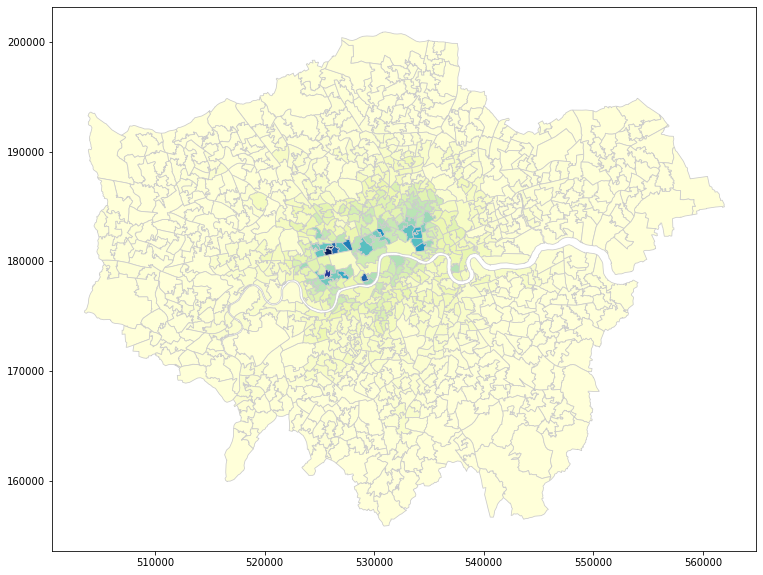

In [115]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 10))
msoas_final.plot(column="airbnb_per_km_sq", cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8')

<AxesSubplot:>

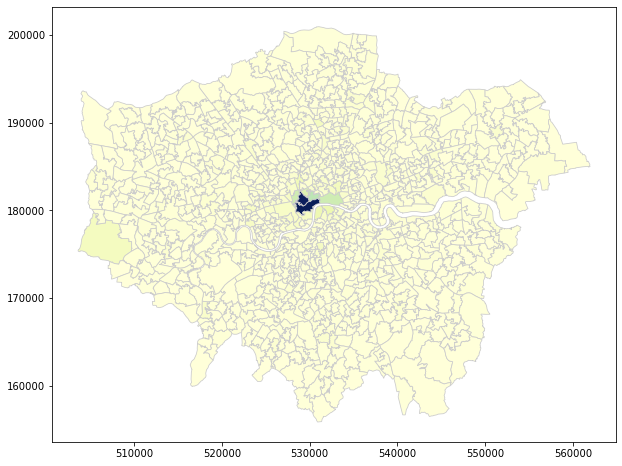

In [117]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))
msoas.plot(column="crime_per_1000", cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8')

## Multiple Linear Regression

In [77]:
model_airbnb_count = sm.formula.ols('crime_per_1000 ~ airbnb_per_km_sq + population_density + unemployment_rate + median_household_income + qualification_low_percentage + ethnic_diversity', msoas_final).fit()
model_airbnb_count.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         crime_per_1000   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     20.78
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           5.31e-23
Time:                        15:30:26   Log-Likelihood:                -4760.3
No. Observations:                 983   AIC:                             9535.
Df Residuals:                     976   BIC:                             9569.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       39.5366     17.011      2.324      0.020       6.154      72.919
airbnb_per_km_sq                 0.0885      0.009      9.715      0.000       0.071       0.106
population_density              -0.2397      0.033     -7.239      0.000      -0.305      -0.175
unemployment_rate                0.9465      0.679      1.394      0.164      -0.386       2.279
median_household_income         -0.0002      0.000     -0.998      0.319      -0.001       0.000
qualification_low_percentage    -0.4195      0.152     -2.756      0.006      -0.718      -0.121
ethnic_diversity                 5.7376     10.528      0.545      0.586     -14.922      26.397
==============================================================================
Omnibus:                     2074.056   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4792795.129
Skew:                          17.073   Prob(JB):                         0.00
Kurtosis:                     343.368   Cond. No.                     6.95e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.95e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True: # while true is true
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df) # take a dataframe and add an initial column 'const' with 1.0 in it

        # Pandas Series is a one-dimensional labeled array capable of holding data of any type (basically a column)
        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [79]:
msoas_final_new = drop_column_using_vif_(msoas_final[["airbnb_per_km_sq", "population_density", "unemployment_rate", "median_household_income", "qualification_low_percentage", "ethnic_diversity"]])

In [80]:
msoas_final_new.columns

Index(['airbnb_per_km_sq', 'population_density', 'unemployment_rate',
       'median_household_income', 'qualification_low_percentage',
       'ethnic_diversity'],
      dtype='object')

In [81]:
# create column for centroid (Easting (X) and Northing (Y)) of each MSOA
msoas_final["X"] = msoas_final.centroid.map(lambda p: p.x)
msoas_final["Y"] = msoas_final.centroid.map(lambda p: p.y)

In [82]:
msoas_final

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,total_pop,crime_per_1000,Middle Super Output Area,population_density,qualification_low_percentage,median_household_income,unemployment_rate,ethnic_diversity,X,Y
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,...,10938,154.690071,E02000001,26.2,24.781643,46788,3.8,0.363437,532482.848974,181269.533434
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,...,7726,4.400725,E02000002,31.7,71.596338,27059,11.8,0.532400,548312.756663,189881.430643
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,...,11246,5.157389,E02000003,47.7,65.029495,36835,9.1,0.622101,548454.924397,188400.157863
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,...,6646,1.956064,E02000004,25.3,73.525872,39668,9.3,0.329349,551009.063353,186311.121270
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,...,10540,4.174573,E02000005,72.9,71.612700,29156,9.7,0.515291,548667.268374,186903.154304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,6784,E02006927,Greenwich 034,Greenwich 034,540764,175168,0.024735,51.45799,2.526112e+06,8592.913078,...,10680,4.962547,E02006927,32.5,54.508072,38143,7.8,0.469513,540690.708844,175179.181067
979,6785,E02006928,Greenwich 035,Greenwich 035,537902,177439,-0.015540,51.47910,5.405753e+05,6849.063388,...,12660,10.584518,E02006928,144.4,47.110965,33988,8.4,0.598806,537699.892380,177616.852129
980,6786,E02006929,Greenwich 036,Greenwich 036,540018,179089,0.015558,51.49341,2.550052e+06,13109.533457,...,13649,13.773903,E02006929,31.3,44.398952,35028,6.5,0.563574,539749.629994,179078.226017
981,6787,E02006930,Greenwich 037,Greenwich 037,540116,178336,0.016670,51.48662,8.679553e+05,7492.395145,...,9263,8.312642,E02006930,77.7,37.830070,46180,5.3,0.377601,539774.154621,178276.828801


In [83]:
# define the variables and geographic coordinates
l_y = msoas_final["crime_per_1000"].values.reshape((-1, 1))
dep_con = ["airbnb_per_km_sq", "population_density", "unemployment_rate", "median_household_income", "qualification_low_percentage", "ethnic_diversity"]
l_X = msoas_final[dep_con].values
u = msoas_final['X']
v = msoas_final['Y']
l_coords = list(zip(u, v))

In [84]:
gwr_selector = Sel_BW(l_coords, l_y, l_X)
gwr_bw = gwr_selector.search()
print(gwr_bw)

86.0


In [85]:
gwr_model = GWR(l_coords, l_y, l_X, gwr_bw)
gwr_results = gwr_model.fit()
print(gwr_results.resid_ss)

384454.0912290813


In [86]:
msoas_final['R2'] = gwr_results.localR2

<AxesSubplot:>

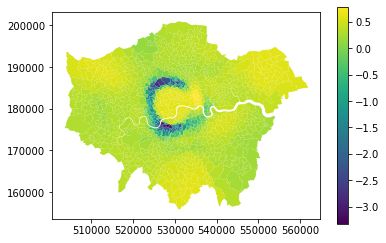

In [87]:
msoas_final.plot('R2', legend = True)

In [88]:
msoas_final['R2'].max()

0.7883645430500055

In [89]:
msoas_final['R2'].mean()

0.2261122340755293

In [90]:
gwr_results.params

array([[ 1.30290517e+02,  1.99031096e-01, -1.72379823e+00, ...,
         6.81826030e-04,  2.72392441e+00, -4.04542294e+01],
       [ 2.60574621e+01,  3.55559252e-01, -7.20696973e-02, ...,
        -1.57294917e-04, -2.32905784e-01, -1.21882959e+01],
       [ 2.68146629e+01,  3.18216694e-01, -7.00614504e-02, ...,
        -1.49002605e-04, -2.43592358e-01, -1.23711087e+01],
       ...,
       [ 5.59363495e+01,  3.63672870e-03, -4.77413470e-02, ...,
        -4.66521875e-04, -6.29096821e-01, -5.35661060e+00],
       [ 5.34792505e+01,  7.99287078e-03, -5.59030972e-02, ...,
        -4.49051335e-04, -5.62295190e-01, -6.11370746e+00],
       [ 5.02827026e+01,  6.59611412e-03, -6.65500377e-02, ...,
        -4.21260866e-04, -5.83786078e-01, -2.75387892e+00]])

In [91]:
msoas_final['gwr_intercept'] = gwr_results.params[:, 0]

<AxesSubplot:>

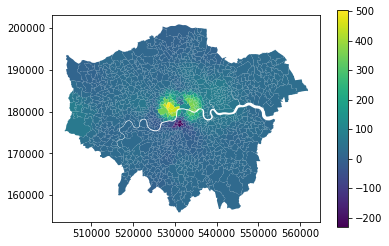

In [92]:
msoas_final.plot('gwr_intercept', legend = True)

In [100]:
msoas_final["gwr_airbnb"] = gwr_results.params[:, 1]

<AxesSubplot:>

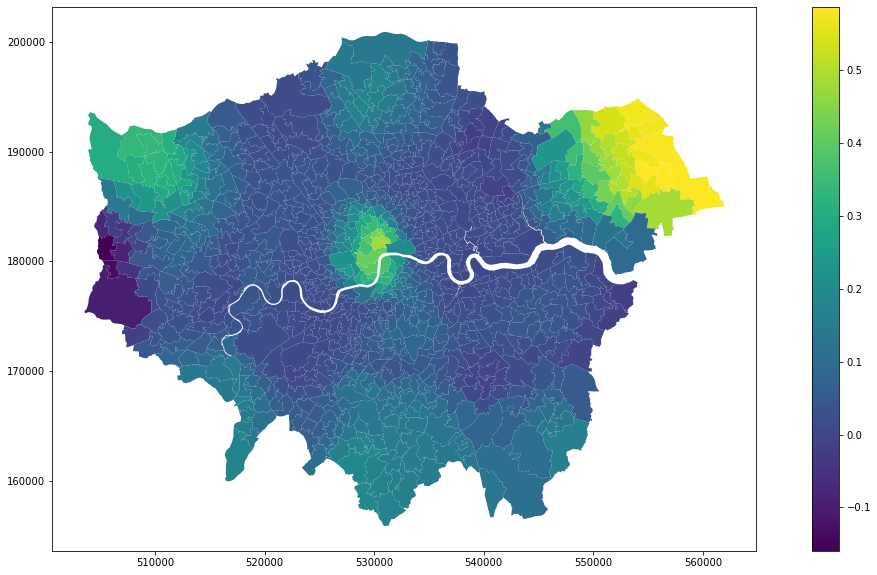

In [116]:
fig, ax = plt.subplots(1, figsize=(20,10))
msoas_final.plot('gwr_airbnb', legend = True, ax= ax)

In [98]:
filter_t = gwr_results.filter_tvals(alpha=0.05)

In [102]:
msoas_final['gwr_airbnb_sig'] = filter_t[:,1]

<AxesSubplot:>

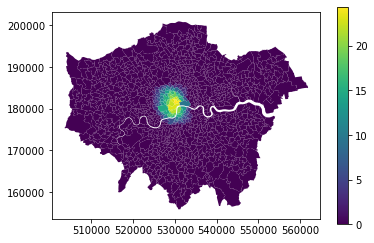

In [103]:
msoas_final.plot('gwr_airbnb_sig', legend = True)

<AxesSubplot:>

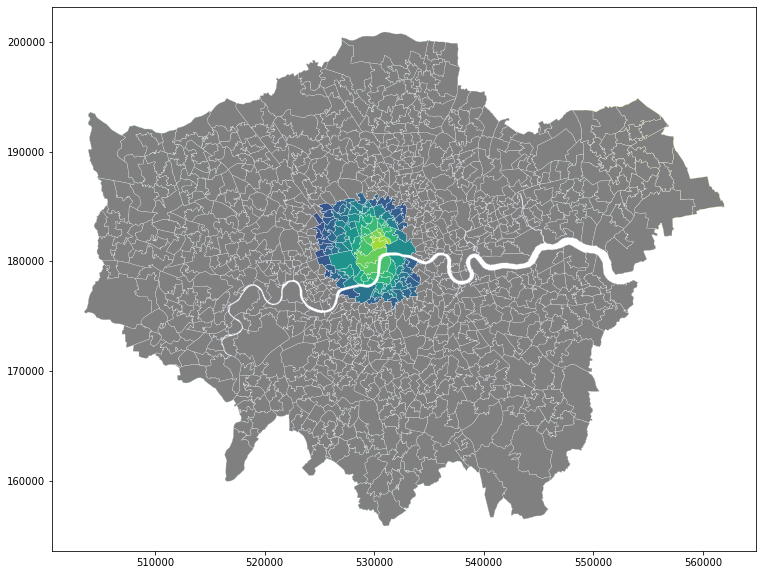

In [114]:
fig, ax = plt.subplots(1, figsize=(20,10))
msoas_final.plot('gwr_airbnb', edgecolor = 'white', linewidth=.25, ax=ax)
msoas_final[filter_t[:,1] == 0].plot(color='grey', ax=ax, edgecolor = 'white', linewidth=.25)